# Class-Conditioned DDPM for CRCHistoPhenotypes

Adapted from [HuggingFace Diffusion Models Class](https://github.com/huggingface/diffusion-models-class)

**Dataset**: CRCHistoPhenotypes (32x32 RGB, 4 classes)
- Epithelial, Fibroblast, Inflammatory, Others

**Method**: Class conditioning via channel concatenation with learned embeddings

## Setup

In [1]:
import os
from pathlib import Path

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import numpy as np

# Device
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

C:\Users\user\anaconda3\envs\test_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
# Configuration
DATASET_PATH = "CRCHisto_Synthetic/data/biomedical/biomedical"
CHECKPOINT_DIR = "CRCHisto_Synthetic/diffusion_model_checkpoints"
SAMPLE_DIR = "CRCHisto_Synthetic/diffusion_model_samples"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(SAMPLE_DIR, exist_ok=True)

# Hyperparameters
BATCH_SIZE = 128
NUM_EPOCHS = 100
LEARNING_RATE = 1e-4
NUM_CLASSES = 4
CLASS_EMB_SIZE = 4
IMAGE_SIZE = 32

# Class names
CLASS_NAMES = ['epithelial', 'fibroblast', 'inflammatory', 'others']
CLASS_TO_IDX = {name: idx for idx, name in enumerate(CLASS_NAMES)}
IDX_TO_CLASS = {idx: name for name, idx in CLASS_TO_IDX.items()}

## Dataset

In [3]:
class CRCDataset(Dataset):
    """CRCHistoPhenotypes Dataset"""

    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = Path(root_dir) / split
        self.samples = []

        for class_name in CLASS_NAMES:
            class_dir = self.root_dir / class_name
            if class_dir.exists():
                for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
                    for img_path in class_dir.glob(ext):
                        self.samples.append((img_path, CLASS_TO_IDX[class_name]))

        self.transform = transform or transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # [-1, 1]
        ])

        print(f"Loaded {len(self.samples)} images from {split}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        return image, label

Loaded 20444 images from train
Batch shape: torch.Size([128, 3, 32, 32])
Labels: tensor([2, 1, 0, 1, 1, 0, 0, 0])
Label names: ['inflammatory', 'fibroblast', 'epithelial', 'fibroblast', 'fibroblast', 'epithelial', 'epithelial', 'epithelial']


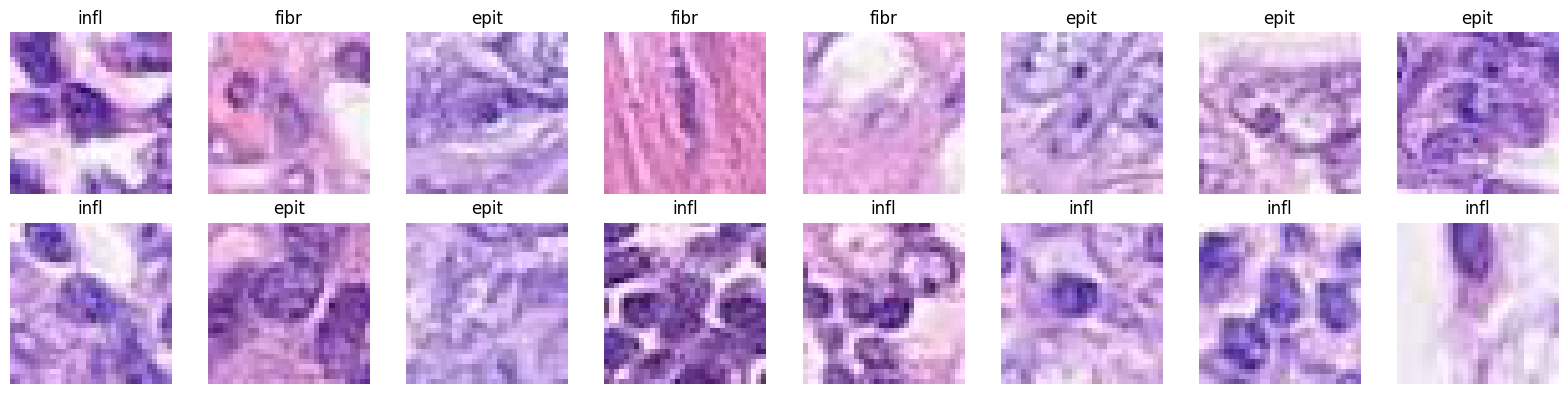

In [4]:
# Load dataset
train_dataset = CRCDataset(DATASET_PATH, split='train')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)

# View samples
x, y = next(iter(train_loader))
print(f'Batch shape: {x.shape}')
print(f'Labels: {y[:8]}')
print(f'Label names: {[IDX_TO_CLASS[l.item()] for l in y[:8]]}')

# Display
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axes.flat):
    img = (x[i].permute(1, 2, 0) * 0.5 + 0.5).numpy()
    ax.imshow(img)
    ax.set_title(IDX_TO_CLASS[y[i].item()][:4])
    ax.axis('off')
plt.tight_layout()
plt.show()

## Class-Conditioned UNet

Class conditioning via channel concatenation:
1. Map class label → learned embedding vector (size `class_emb_size`)
2. Expand embedding spatially to match image size
3. Concatenate with noisy image as extra input channels
4. Feed to UNet (input channels = 3 + class_emb_size)

In [5]:
class ClassConditionedUnet(nn.Module):
    def __init__(self, num_classes=4, class_emb_size=4):
        super().__init__()

        # Class embedding layer
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        # UNet with extra input channels for class conditioning
        self.model = UNet2DModel(
            sample_size=32,                      # 32x32 images
            in_channels=3 + class_emb_size,      # RGB + class embedding
            out_channels=3,                      # RGB output
            layers_per_block=2,
            block_out_channels=(64, 128, 128, 256),
            down_block_types=(
                "DownBlock2D",
                "DownBlock2D",
                "AttnDownBlock2D",
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",
                "UpBlock2D",
                "UpBlock2D",
            ),
        )

    def forward(self, x, t, class_labels):
        # x: (bs, 3, 32, 32)
        bs, ch, h, w = x.shape

        # Get class embedding and expand spatially
        class_cond = self.class_emb(class_labels)  # (bs, class_emb_size)
        class_cond = class_cond.view(bs, -1, 1, 1).expand(bs, -1, h, w)  # (bs, class_emb_size, 32, 32)

        # Concatenate image with class conditioning
        net_input = torch.cat([x, class_cond], dim=1)  # (bs, 3 + class_emb_size, 32, 32)

        # Forward through UNet
        return self.model(net_input, t).sample

In [6]:
# Create model
model = ClassConditionedUnet(num_classes=NUM_CLASSES, class_emb_size=CLASS_EMB_SIZE).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {num_params:,} ({num_params/1e6:.1f}M)")

# Test forward pass
with torch.no_grad():
    test_x = torch.randn(2, 3, 32, 32, device=device)
    test_t = torch.tensor([500, 100], device=device)
    test_labels = torch.tensor([0, 1], device=device)
    out = model(test_x, test_t, test_labels)
    print(f"Input: {test_x.shape} -> Output: {out.shape}")

Model parameters: 18,538,643 (18.5M)
Input: torch.Size([2, 3, 32, 32]) -> Output: torch.Size([2, 3, 32, 32])


## Noise Scheduler

In [7]:
# DDPM Scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule='squaredcos_cap_v2'  # Cosine schedule (better for small images)
)

print(f"Scheduler config: {noise_scheduler.config}")

Scheduler config: FrozenDict({'num_train_timesteps': 1000, 'beta_start': 0.0001, 'beta_end': 0.02, 'beta_schedule': 'squaredcos_cap_v2', 'trained_betas': None, 'variance_type': 'fixed_small', 'clip_sample': True, 'prediction_type': 'epsilon', 'thresholding': False, 'dynamic_thresholding_ratio': 0.995, 'clip_sample_range': 1.0, 'sample_max_value': 1.0, 'timestep_spacing': 'leading', 'steps_offset': 0, 'rescale_betas_zero_snr': False, '_use_default_values': ['beta_end', 'sample_max_value', 'beta_start', 'timestep_spacing', 'prediction_type', 'thresholding', 'dynamic_thresholding_ratio', 'variance_type', 'steps_offset', 'clip_sample', 'trained_betas', 'clip_sample_range', 'rescale_betas_zero_snr']})


## Training

In [8]:
@torch.no_grad()
def generate_samples(model, scheduler, num_samples=16, class_labels=None):
    """Generate samples using reverse diffusion"""
    model.eval()

    if class_labels is None:
        # 4 samples per class
        class_labels = torch.arange(NUM_CLASSES, device=device).repeat_interleave(num_samples // NUM_CLASSES)

    # Start from noise
    x = torch.randn(len(class_labels), 3, IMAGE_SIZE, IMAGE_SIZE, device=device)

    # Reverse diffusion
    for t in tqdm(scheduler.timesteps, desc="Sampling"):
        t_batch = torch.full((len(class_labels),), t, device=device, dtype=torch.long)
        noise_pred = model(x, t_batch, class_labels)
        x = scheduler.step(noise_pred, t, x).prev_sample

    # Denormalize to [0, 1]
    x = (x.clamp(-1, 1) + 1) / 2
    return x

In [9]:
import re
import glob

def find_latest_checkpoint(checkpoint_dir):
    """Find the latest checkpoint based on epoch number"""
    checkpoint_pattern = os.path.join(checkpoint_dir,
'checkpoint_epoch_*.pt')
    checkpoints = glob.glob(checkpoint_pattern)

    if not checkpoints:
        return None, 0

    # Extract epoch numbers and find max
    latest_checkpoint = None
    latest_epoch = 0

    for ckpt in checkpoints:
        match = re.search(r'checkpoint_epoch_(\d+)\.pt', ckpt)
        if match:
            epoch = int(match.group(1))
            if epoch > latest_epoch:
                latest_epoch = epoch
                latest_checkpoint = ckpt

    return latest_checkpoint, latest_epoch

No checkpoint found. Starting training from scratch.


Epoch 1/100: 100%|██████████████| 159/159 [01:07<00:00,  2.35it/s, loss=0.1034]


Epoch 1 - Average Loss: 0.2082


Epoch 2/100: 100%|██████████████| 159/159 [01:07<00:00,  2.35it/s, loss=0.0803]


Epoch 2 - Average Loss: 0.0909


Epoch 3/100: 100%|██████████████| 159/159 [01:05<00:00,  2.42it/s, loss=0.0733]


Epoch 3 - Average Loss: 0.0813


Epoch 4/100: 100%|██████████████| 159/159 [01:04<00:00,  2.47it/s, loss=0.0711]


Epoch 4 - Average Loss: 0.0742


Epoch 5/100: 100%|██████████████| 159/159 [01:07<00:00,  2.36it/s, loss=0.0719]


Epoch 5 - Average Loss: 0.0719


Sampling: 100%|████████████████████████████| 1000/1000 [00:51<00:00, 19.48it/s]


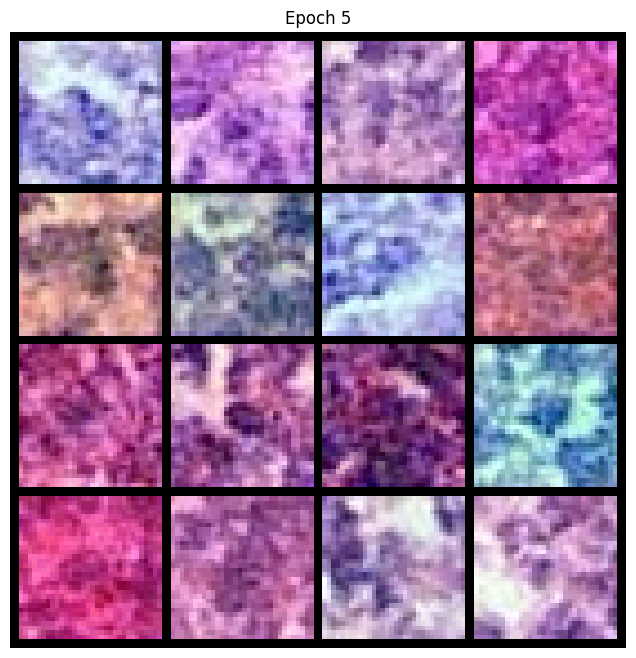

Epoch 6/100: 100%|██████████████| 159/159 [01:06<00:00,  2.40it/s, loss=0.0631]


Epoch 6 - Average Loss: 0.0702


Epoch 7/100: 100%|██████████████| 159/159 [01:06<00:00,  2.38it/s, loss=0.0599]


Epoch 7 - Average Loss: 0.0694


Epoch 8/100: 100%|██████████████| 159/159 [01:06<00:00,  2.38it/s, loss=0.0689]


Epoch 8 - Average Loss: 0.0679


Epoch 9/100: 100%|██████████████| 159/159 [01:06<00:00,  2.38it/s, loss=0.0575]


Epoch 9 - Average Loss: 0.0657


Epoch 10/100: 100%|█████████████| 159/159 [01:05<00:00,  2.41it/s, loss=0.0633]


Epoch 10 - Average Loss: 0.0659
Saved checkpoint at epoch 10


Sampling: 100%|████████████████████████████| 1000/1000 [00:49<00:00, 20.19it/s]


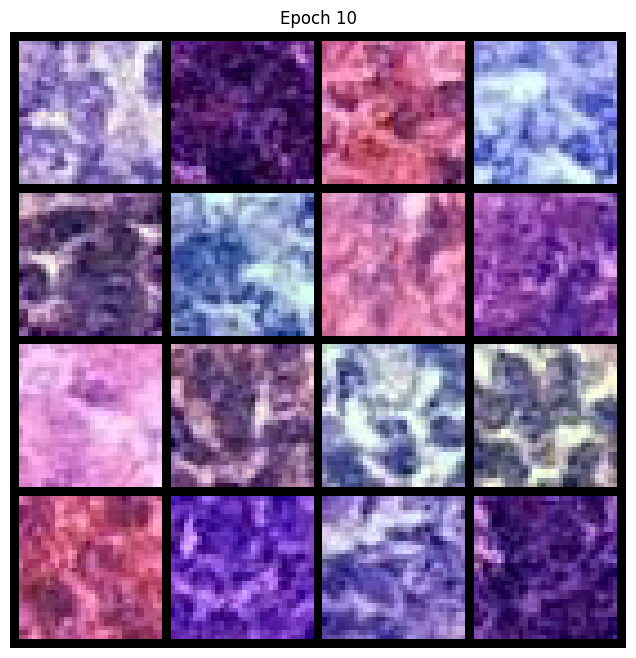

Epoch 11/100: 100%|█████████████| 159/159 [01:08<00:00,  2.32it/s, loss=0.0533]


Epoch 11 - Average Loss: 0.0644


Epoch 12/100: 100%|█████████████| 159/159 [01:07<00:00,  2.34it/s, loss=0.0564]


Epoch 12 - Average Loss: 0.0632


Epoch 13/100: 100%|█████████████| 159/159 [01:05<00:00,  2.41it/s, loss=0.0674]


Epoch 13 - Average Loss: 0.0642


Epoch 14/100: 100%|█████████████| 159/159 [01:06<00:00,  2.39it/s, loss=0.0634]


Epoch 14 - Average Loss: 0.0637


Epoch 15/100: 100%|█████████████| 159/159 [01:06<00:00,  2.38it/s, loss=0.0649]


Epoch 15 - Average Loss: 0.0622


Sampling: 100%|████████████████████████████| 1000/1000 [00:48<00:00, 20.65it/s]


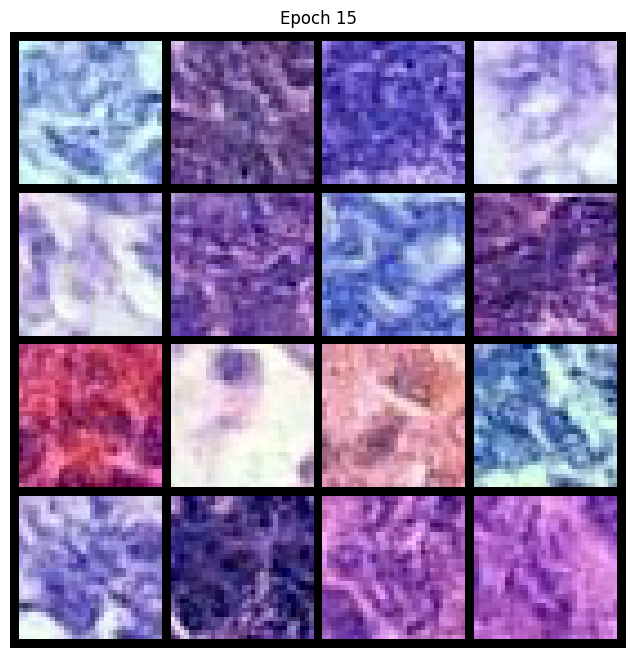

Epoch 16/100: 100%|█████████████| 159/159 [01:05<00:00,  2.42it/s, loss=0.0739]


Epoch 16 - Average Loss: 0.0621


Epoch 17/100: 100%|█████████████| 159/159 [01:07<00:00,  2.34it/s, loss=0.0748]


Epoch 17 - Average Loss: 0.0624


Epoch 18/100: 100%|█████████████| 159/159 [01:08<00:00,  2.33it/s, loss=0.0497]


Epoch 18 - Average Loss: 0.0612


Epoch 19/100: 100%|█████████████| 159/159 [01:06<00:00,  2.41it/s, loss=0.0703]


Epoch 19 - Average Loss: 0.0610


Epoch 20/100: 100%|█████████████| 159/159 [01:07<00:00,  2.37it/s, loss=0.0663]


Epoch 20 - Average Loss: 0.0605
Saved checkpoint at epoch 20


Sampling: 100%|████████████████████████████| 1000/1000 [00:47<00:00, 20.91it/s]


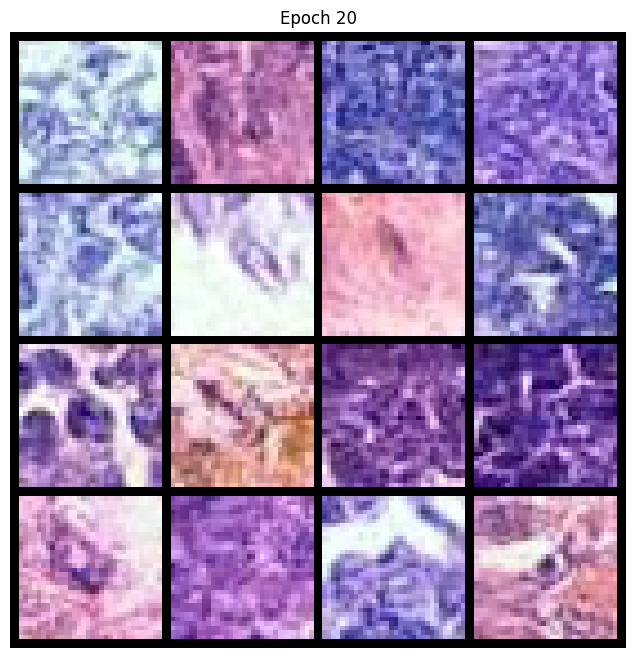

Epoch 21/100: 100%|█████████████| 159/159 [01:07<00:00,  2.35it/s, loss=0.0569]


Epoch 21 - Average Loss: 0.0609


Epoch 22/100: 100%|█████████████| 159/159 [01:06<00:00,  2.38it/s, loss=0.0606]


Epoch 22 - Average Loss: 0.0613


Epoch 23/100: 100%|█████████████| 159/159 [01:06<00:00,  2.38it/s, loss=0.0669]


Epoch 23 - Average Loss: 0.0601


Epoch 24/100: 100%|█████████████| 159/159 [01:08<00:00,  2.32it/s, loss=0.0672]


Epoch 24 - Average Loss: 0.0595


Epoch 25/100: 100%|█████████████| 159/159 [01:06<00:00,  2.38it/s, loss=0.0612]


Epoch 25 - Average Loss: 0.0604


Sampling: 100%|████████████████████████████| 1000/1000 [00:49<00:00, 20.09it/s]


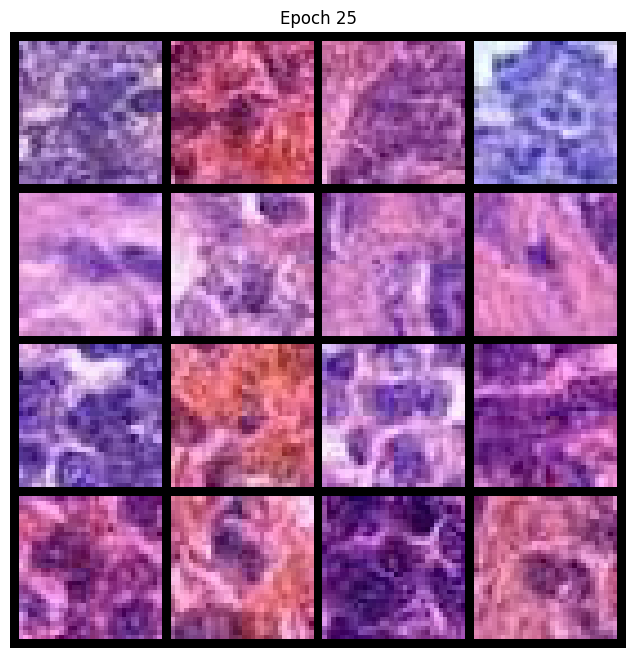

Epoch 26/100: 100%|█████████████| 159/159 [01:07<00:00,  2.37it/s, loss=0.0700]


Epoch 26 - Average Loss: 0.0596


Epoch 27/100: 100%|█████████████| 159/159 [01:07<00:00,  2.36it/s, loss=0.0562]


Epoch 27 - Average Loss: 0.0600


Epoch 28/100: 100%|█████████████| 159/159 [01:06<00:00,  2.38it/s, loss=0.0554]


Epoch 28 - Average Loss: 0.0599


Epoch 29/100: 100%|█████████████| 159/159 [01:05<00:00,  2.41it/s, loss=0.0527]


Epoch 29 - Average Loss: 0.0586


Epoch 30/100: 100%|█████████████| 159/159 [01:06<00:00,  2.40it/s, loss=0.0649]


Epoch 30 - Average Loss: 0.0588
Saved checkpoint at epoch 30


Sampling: 100%|████████████████████████████| 1000/1000 [00:51<00:00, 19.30it/s]


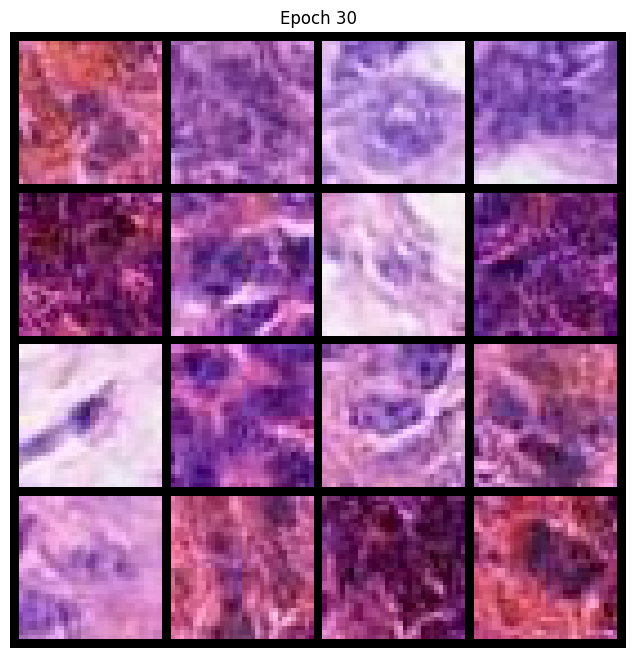

Epoch 31/100: 100%|█████████████| 159/159 [01:06<00:00,  2.39it/s, loss=0.0593]


Epoch 31 - Average Loss: 0.0581


Epoch 32/100: 100%|█████████████| 159/159 [01:07<00:00,  2.37it/s, loss=0.0584]


Epoch 32 - Average Loss: 0.0579


Epoch 33/100: 100%|█████████████| 159/159 [01:07<00:00,  2.36it/s, loss=0.0642]


Epoch 33 - Average Loss: 0.0578


Epoch 34/100: 100%|█████████████| 159/159 [01:07<00:00,  2.36it/s, loss=0.0456]


Epoch 34 - Average Loss: 0.0583


Epoch 35/100: 100%|█████████████| 159/159 [01:06<00:00,  2.41it/s, loss=0.0539]


Epoch 35 - Average Loss: 0.0580


Sampling: 100%|████████████████████████████| 1000/1000 [00:50<00:00, 19.99it/s]


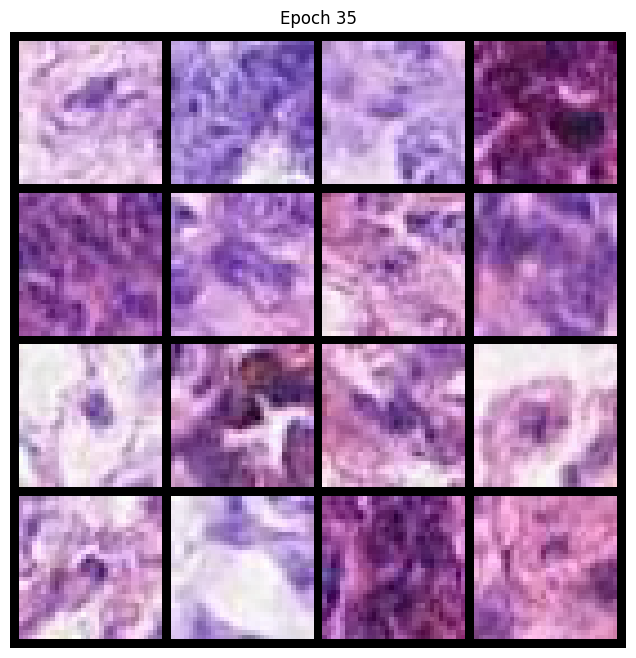

Epoch 36/100: 100%|█████████████| 159/159 [01:08<00:00,  2.32it/s, loss=0.0459]


Epoch 36 - Average Loss: 0.0580


Epoch 37/100: 100%|█████████████| 159/159 [01:07<00:00,  2.36it/s, loss=0.0499]


Epoch 37 - Average Loss: 0.0581


Epoch 38/100: 100%|█████████████| 159/159 [01:06<00:00,  2.40it/s, loss=0.0554]


Epoch 38 - Average Loss: 0.0577


Epoch 39/100: 100%|█████████████| 159/159 [01:07<00:00,  2.37it/s, loss=0.0649]


Epoch 39 - Average Loss: 0.0577


Epoch 40/100: 100%|█████████████| 159/159 [01:07<00:00,  2.35it/s, loss=0.0761]


Epoch 40 - Average Loss: 0.0581
Saved checkpoint at epoch 40


Sampling: 100%|████████████████████████████| 1000/1000 [00:48<00:00, 20.69it/s]


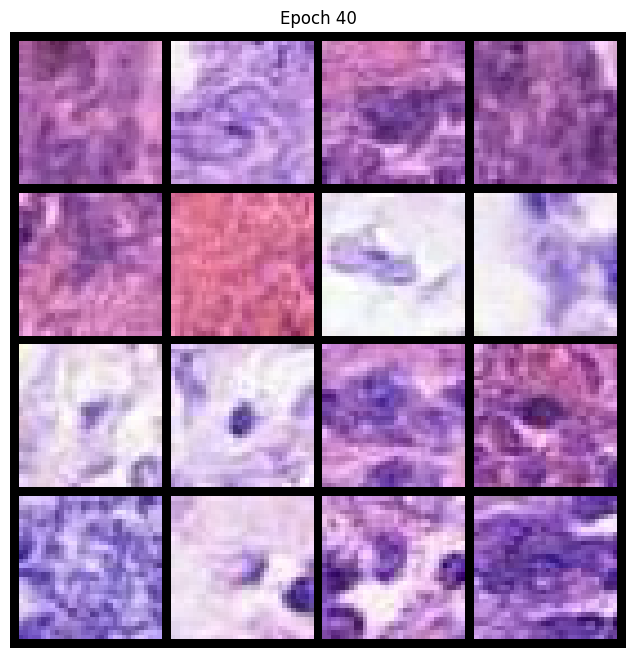

Epoch 41/100: 100%|█████████████| 159/159 [01:05<00:00,  2.42it/s, loss=0.0562]


Epoch 41 - Average Loss: 0.0578


Epoch 42/100: 100%|█████████████| 159/159 [01:08<00:00,  2.32it/s, loss=0.0623]


Epoch 42 - Average Loss: 0.0575


Epoch 43/100: 100%|█████████████| 159/159 [01:08<00:00,  2.32it/s, loss=0.0463]


Epoch 43 - Average Loss: 0.0571


Epoch 44/100: 100%|█████████████| 159/159 [01:06<00:00,  2.40it/s, loss=0.0695]


Epoch 44 - Average Loss: 0.0574


Epoch 45/100: 100%|█████████████| 159/159 [01:07<00:00,  2.37it/s, loss=0.0555]


Epoch 45 - Average Loss: 0.0570


Sampling: 100%|████████████████████████████| 1000/1000 [00:49<00:00, 20.21it/s]


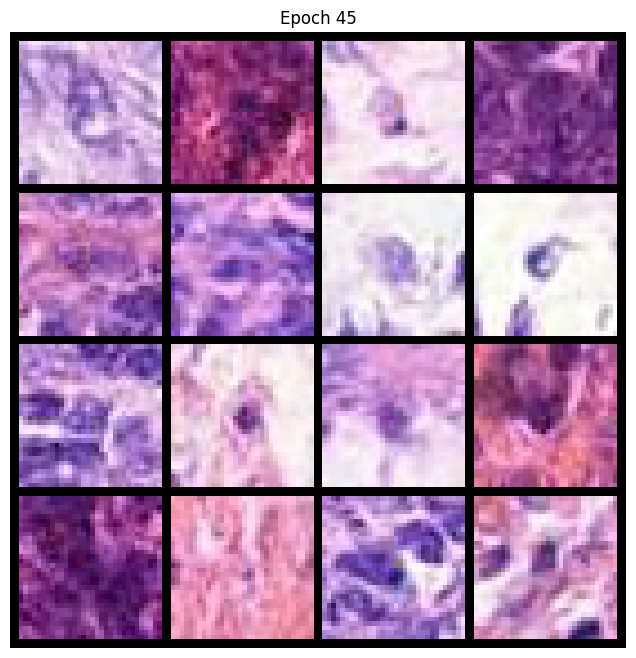

Epoch 46/100: 100%|█████████████| 159/159 [01:07<00:00,  2.36it/s, loss=0.0552]


Epoch 46 - Average Loss: 0.0573


Epoch 47/100: 100%|█████████████| 159/159 [01:05<00:00,  2.42it/s, loss=0.0527]


Epoch 47 - Average Loss: 0.0564


Epoch 48/100: 100%|█████████████| 159/159 [01:07<00:00,  2.37it/s, loss=0.0518]


Epoch 48 - Average Loss: 0.0570


Epoch 49/100: 100%|█████████████| 159/159 [01:08<00:00,  2.32it/s, loss=0.0634]


Epoch 49 - Average Loss: 0.0563


Epoch 50/100: 100%|█████████████| 159/159 [01:06<00:00,  2.38it/s, loss=0.0629]


Epoch 50 - Average Loss: 0.0565
Saved checkpoint at epoch 50


Sampling: 100%|████████████████████████████| 1000/1000 [00:49<00:00, 20.22it/s]


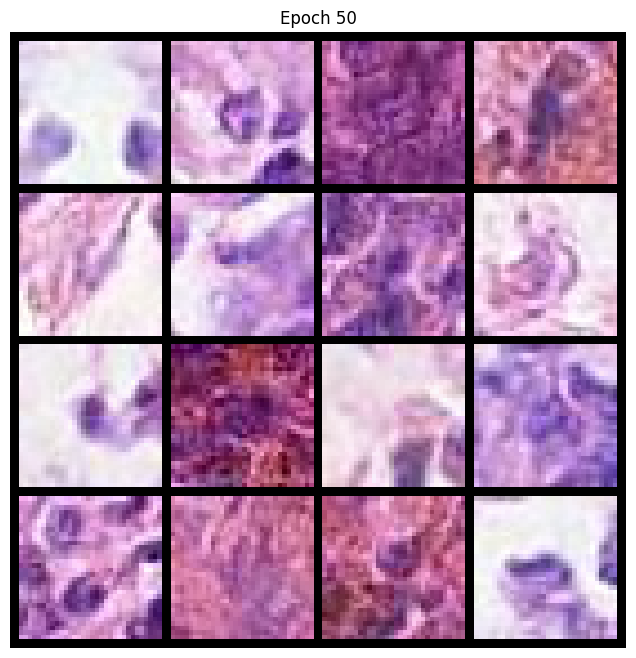

Epoch 51/100: 100%|█████████████| 159/159 [01:07<00:00,  2.35it/s, loss=0.0452]


Epoch 51 - Average Loss: 0.0567


Epoch 52/100: 100%|█████████████| 159/159 [01:07<00:00,  2.35it/s, loss=0.0594]


Epoch 52 - Average Loss: 0.0569


Epoch 53/100: 100%|█████████████| 159/159 [01:05<00:00,  2.41it/s, loss=0.0610]


Epoch 53 - Average Loss: 0.0571


Epoch 54/100: 100%|█████████████| 159/159 [01:05<00:00,  2.42it/s, loss=0.0520]


Epoch 54 - Average Loss: 0.0570


Epoch 55/100: 100%|█████████████| 159/159 [01:08<00:00,  2.34it/s, loss=0.0602]


Epoch 55 - Average Loss: 0.0559


Sampling: 100%|████████████████████████████| 1000/1000 [00:51<00:00, 19.24it/s]


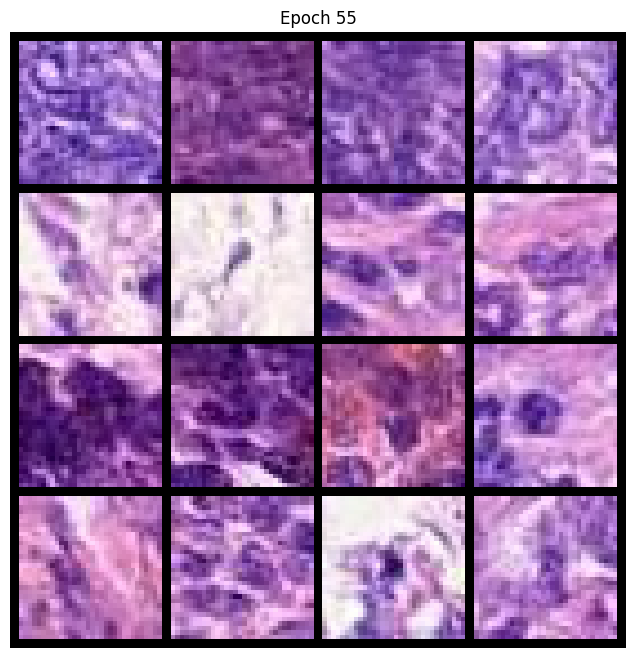

Epoch 56/100: 100%|█████████████| 159/159 [01:06<00:00,  2.40it/s, loss=0.0586]


Epoch 56 - Average Loss: 0.0566


Epoch 57/100: 100%|█████████████| 159/159 [01:06<00:00,  2.38it/s, loss=0.0529]


Epoch 57 - Average Loss: 0.0565


Epoch 58/100: 100%|█████████████| 159/159 [01:07<00:00,  2.36it/s, loss=0.0587]


Epoch 58 - Average Loss: 0.0561


Epoch 59/100: 100%|█████████████| 159/159 [01:06<00:00,  2.40it/s, loss=0.0597]


Epoch 59 - Average Loss: 0.0559


Epoch 60/100: 100%|█████████████| 159/159 [01:05<00:00,  2.45it/s, loss=0.0523]


Epoch 60 - Average Loss: 0.0561
Saved checkpoint at epoch 60


Sampling: 100%|████████████████████████████| 1000/1000 [00:46<00:00, 21.62it/s]


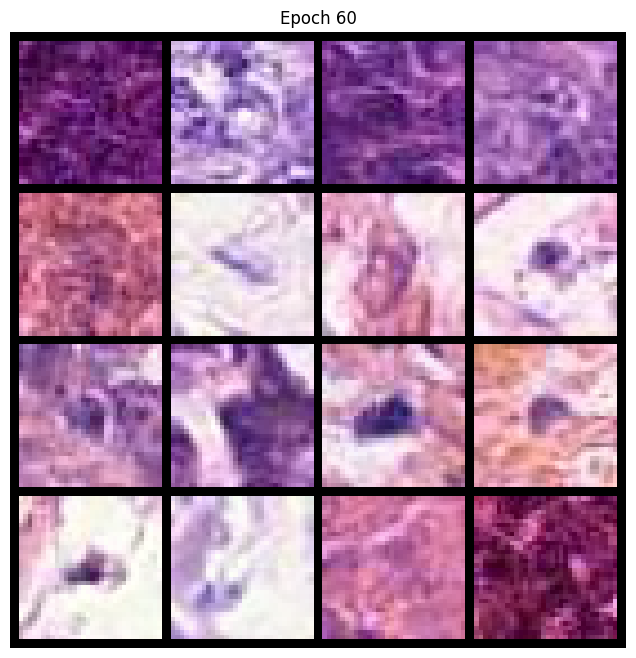

Epoch 61/100: 100%|█████████████| 159/159 [01:07<00:00,  2.36it/s, loss=0.0629]


Epoch 61 - Average Loss: 0.0554


Epoch 62/100: 100%|█████████████| 159/159 [01:06<00:00,  2.39it/s, loss=0.0561]


Epoch 62 - Average Loss: 0.0567


Epoch 63/100: 100%|█████████████| 159/159 [01:05<00:00,  2.41it/s, loss=0.0552]


Epoch 63 - Average Loss: 0.0564


Epoch 64/100: 100%|█████████████| 159/159 [01:06<00:00,  2.38it/s, loss=0.0654]


Epoch 64 - Average Loss: 0.0561


Epoch 65/100: 100%|█████████████| 159/159 [01:07<00:00,  2.36it/s, loss=0.0531]


Epoch 65 - Average Loss: 0.0564


Sampling: 100%|████████████████████████████| 1000/1000 [00:44<00:00, 22.35it/s]


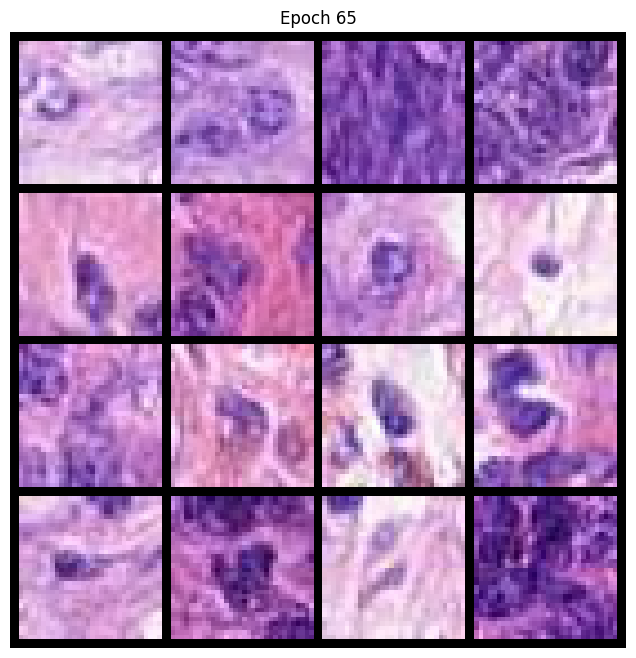

Epoch 66/100: 100%|█████████████| 159/159 [01:04<00:00,  2.47it/s, loss=0.0629]


Epoch 66 - Average Loss: 0.0563


Epoch 67/100: 100%|█████████████| 159/159 [01:07<00:00,  2.37it/s, loss=0.0640]


Epoch 67 - Average Loss: 0.0559


Epoch 68/100: 100%|█████████████| 159/159 [01:07<00:00,  2.35it/s, loss=0.0583]


Epoch 68 - Average Loss: 0.0563


Epoch 69/100: 100%|█████████████| 159/159 [01:05<00:00,  2.42it/s, loss=0.0477]


Epoch 69 - Average Loss: 0.0564


Epoch 70/100: 100%|█████████████| 159/159 [01:06<00:00,  2.39it/s, loss=0.0605]


Epoch 70 - Average Loss: 0.0565
Saved checkpoint at epoch 70


Sampling: 100%|████████████████████████████| 1000/1000 [00:45<00:00, 22.01it/s]


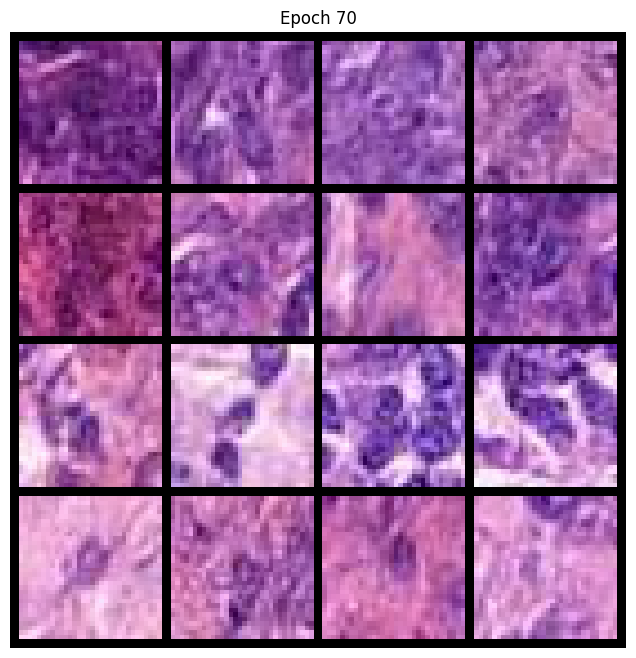

Epoch 71/100: 100%|█████████████| 159/159 [01:07<00:00,  2.37it/s, loss=0.0373]


Epoch 71 - Average Loss: 0.0540


Epoch 72/100: 100%|█████████████| 159/159 [01:05<00:00,  2.42it/s, loss=0.0590]


Epoch 72 - Average Loss: 0.0547


Epoch 73/100: 100%|█████████████| 159/159 [01:06<00:00,  2.39it/s, loss=0.0545]


Epoch 73 - Average Loss: 0.0551


Epoch 74/100: 100%|█████████████| 159/159 [01:08<00:00,  2.32it/s, loss=0.0411]


Epoch 74 - Average Loss: 0.0556


Epoch 75/100: 100%|█████████████| 159/159 [01:06<00:00,  2.38it/s, loss=0.0537]


Epoch 75 - Average Loss: 0.0558


Sampling: 100%|████████████████████████████| 1000/1000 [00:47<00:00, 20.84it/s]


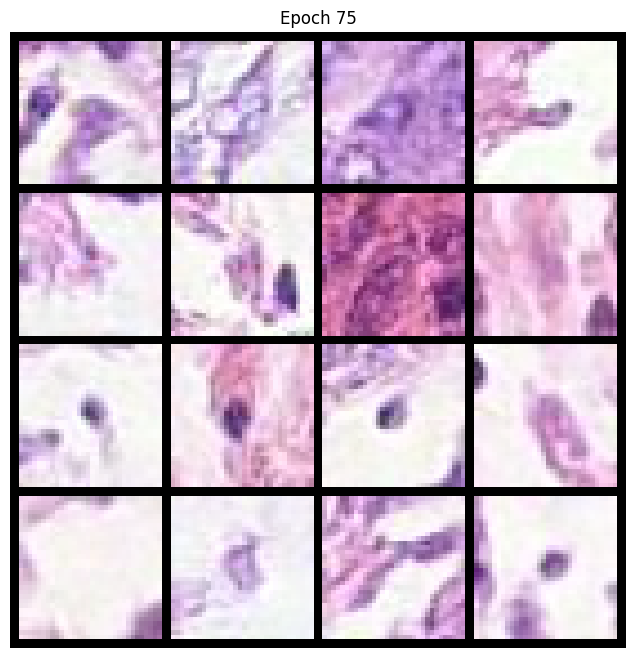

Epoch 76/100: 100%|█████████████| 159/159 [01:07<00:00,  2.35it/s, loss=0.0638]


Epoch 76 - Average Loss: 0.0558


Epoch 77/100: 100%|█████████████| 159/159 [01:07<00:00,  2.34it/s, loss=0.0532]


Epoch 77 - Average Loss: 0.0547


Epoch 78/100: 100%|█████████████| 159/159 [01:06<00:00,  2.40it/s, loss=0.0526]


Epoch 78 - Average Loss: 0.0562


Epoch 79/100: 100%|█████████████| 159/159 [01:05<00:00,  2.43it/s, loss=0.0498]


Epoch 79 - Average Loss: 0.0556


Epoch 80/100: 100%|█████████████| 159/159 [01:07<00:00,  2.37it/s, loss=0.0591]


Epoch 80 - Average Loss: 0.0553
Saved checkpoint at epoch 80


Sampling: 100%|████████████████████████████| 1000/1000 [00:50<00:00, 19.99it/s]


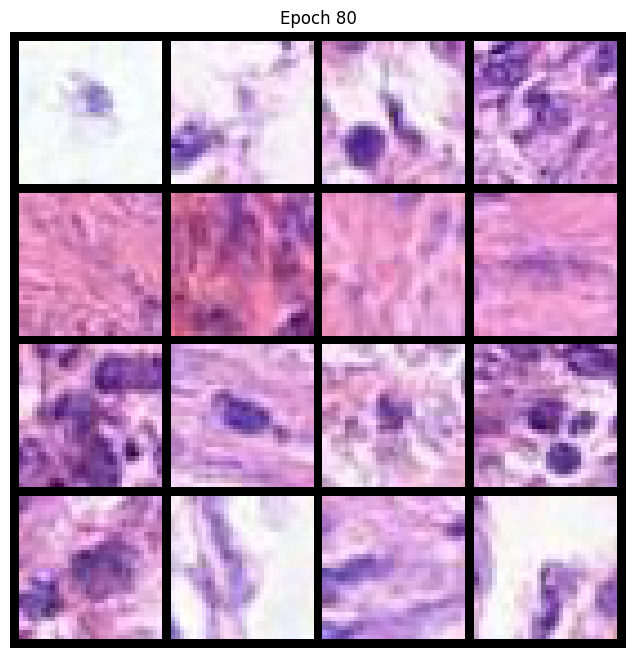

Epoch 81/100: 100%|█████████████| 159/159 [01:06<00:00,  2.39it/s, loss=0.0497]


Epoch 81 - Average Loss: 0.0556


Epoch 82/100: 100%|█████████████| 159/159 [01:06<00:00,  2.39it/s, loss=0.0644]


Epoch 82 - Average Loss: 0.0555


Epoch 83/100: 100%|█████████████| 159/159 [01:07<00:00,  2.37it/s, loss=0.0528]


Epoch 83 - Average Loss: 0.0545


Epoch 84/100: 100%|█████████████| 159/159 [01:07<00:00,  2.37it/s, loss=0.0506]


Epoch 84 - Average Loss: 0.0543


Epoch 85/100: 100%|█████████████| 159/159 [01:05<00:00,  2.43it/s, loss=0.0630]


Epoch 85 - Average Loss: 0.0545


Sampling: 100%|████████████████████████████| 1000/1000 [00:48<00:00, 20.58it/s]


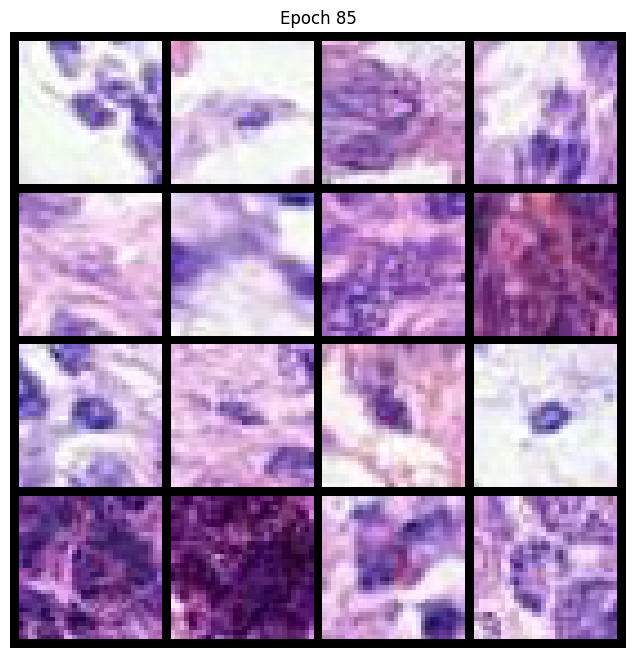

Epoch 86/100: 100%|█████████████| 159/159 [01:08<00:00,  2.34it/s, loss=0.0568]


Epoch 86 - Average Loss: 0.0556


Epoch 87/100: 100%|█████████████| 159/159 [01:07<00:00,  2.34it/s, loss=0.0491]


Epoch 87 - Average Loss: 0.0553


Epoch 88/100: 100%|█████████████| 159/159 [01:05<00:00,  2.41it/s, loss=0.0463]


Epoch 88 - Average Loss: 0.0548


Epoch 89/100: 100%|█████████████| 159/159 [01:07<00:00,  2.37it/s, loss=0.0439]


Epoch 89 - Average Loss: 0.0545


Epoch 90/100: 100%|█████████████| 159/159 [01:06<00:00,  2.37it/s, loss=0.0588]


Epoch 90 - Average Loss: 0.0545
Saved checkpoint at epoch 90


Sampling: 100%|████████████████████████████| 1000/1000 [00:48<00:00, 20.52it/s]


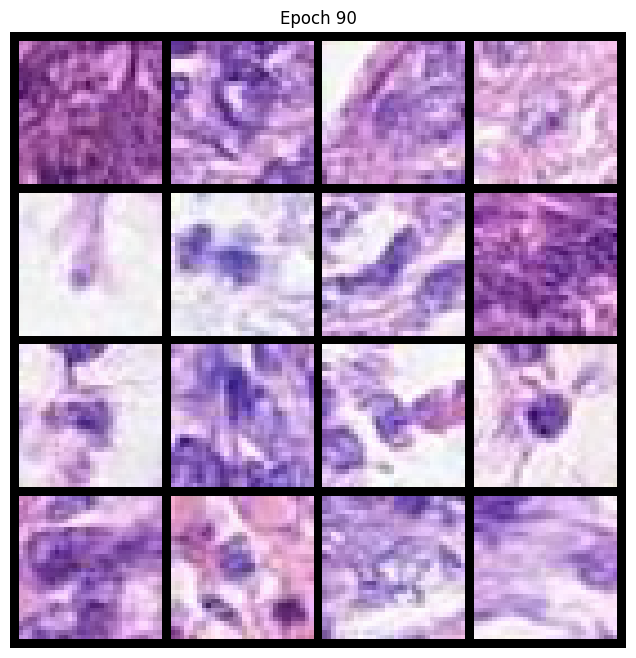

Epoch 91/100: 100%|█████████████| 159/159 [01:06<00:00,  2.41it/s, loss=0.0538]


Epoch 91 - Average Loss: 0.0542


Epoch 92/100: 100%|█████████████| 159/159 [01:07<00:00,  2.37it/s, loss=0.0552]


Epoch 92 - Average Loss: 0.0544


Epoch 93/100: 100%|█████████████| 159/159 [01:07<00:00,  2.34it/s, loss=0.0661]


Epoch 93 - Average Loss: 0.0548


Epoch 94/100: 100%|█████████████| 159/159 [01:05<00:00,  2.43it/s, loss=0.0573]


Epoch 94 - Average Loss: 0.0558


Epoch 95/100: 100%|█████████████| 159/159 [01:06<00:00,  2.41it/s, loss=0.0605]


Epoch 95 - Average Loss: 0.0546


Sampling: 100%|████████████████████████████| 1000/1000 [00:48<00:00, 20.79it/s]


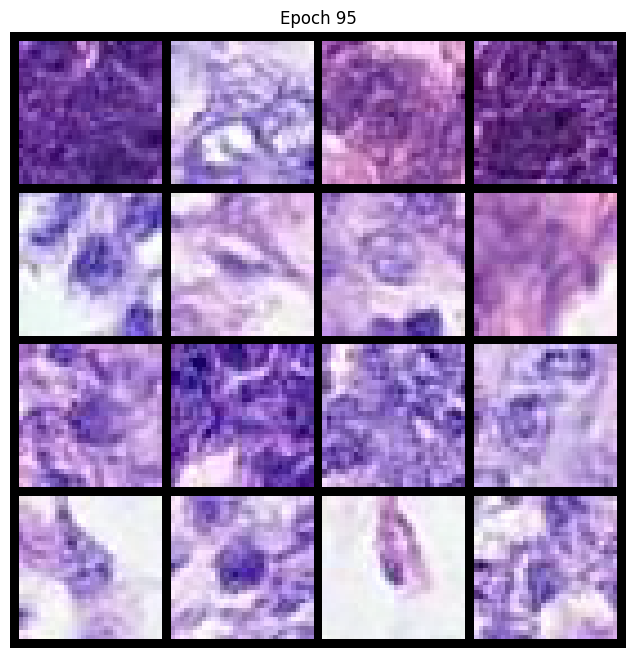

Epoch 96/100: 100%|█████████████| 159/159 [01:08<00:00,  2.34it/s, loss=0.0487]


Epoch 96 - Average Loss: 0.0552


Epoch 97/100: 100%|█████████████| 159/159 [01:05<00:00,  2.42it/s, loss=0.0528]


Epoch 97 - Average Loss: 0.0543


Epoch 98/100: 100%|█████████████| 159/159 [01:05<00:00,  2.42it/s, loss=0.0575]


Epoch 98 - Average Loss: 0.0548


Epoch 99/100: 100%|█████████████| 159/159 [01:08<00:00,  2.34it/s, loss=0.0516]


Epoch 99 - Average Loss: 0.0541


Epoch 100/100: 100%|████████████| 159/159 [01:06<00:00,  2.38it/s, loss=0.0540]


Epoch 100 - Average Loss: 0.0541
Saved checkpoint at epoch 100


Sampling: 100%|████████████████████████████| 1000/1000 [00:49<00:00, 20.17it/s]


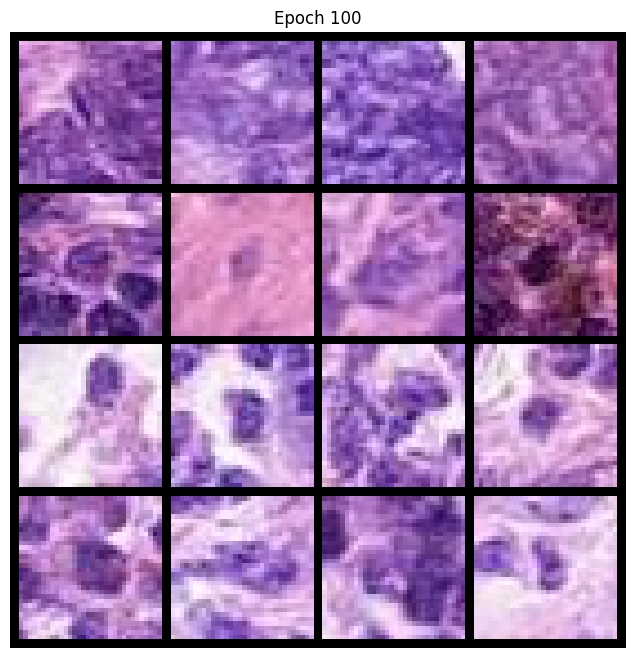

In [10]:
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Training loop
latest_checkpoint, start_epoch = find_latest_checkpoint(CHECKPOINT_DIR)
losses = []

if latest_checkpoint:
    print(f"Found checkpoint: {latest_checkpoint}")
    checkpoint = torch.load(latest_checkpoint, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    if 'losses' in checkpoint:
        losses = checkpoint['losses']
    print(f"Resuming training from epoch {start_epoch + 1}")
else:
    print("No checkpoint found. Starting training from scratch.")
    start_epoch = 0

for epoch in range(start_epoch,NUM_EPOCHS):
    model.train()
    epoch_losses = []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for x, y in pbar:
        x = x.to(device)
        y = y.to(device)

        # Sample random timesteps
        t = torch.randint(0, noise_scheduler.config.num_train_timesteps, (x.shape[0],), device=device)

        # Add noise
        noise = torch.randn_like(x)
        noisy_x = noise_scheduler.add_noise(x, noise, t)

        # Predict noise
        noise_pred = model(noisy_x, t, y)

        # Loss
        loss = F.mse_loss(noise_pred, noise)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = np.mean(epoch_losses)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1} - Average Loss: {avg_loss:.4f}")

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            'losses': losses,  # Save all losses for plotting
        }, os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch+1}.pt'))
        print(f"Saved checkpoint at epoch {epoch+1}")

    # Generate samples every 5 epochs
    if (epoch + 1) % 5 == 0:
        samples = generate_samples(model, noise_scheduler, num_samples=16)
        save_image(samples, os.path.join(SAMPLE_DIR, f'samples_epoch_{epoch+1}.png'), nrow=4)

        # Display
        grid = make_grid(samples, nrow=4)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.title(f"Epoch {epoch+1}")
        plt.axis('off')
        plt.show()

        model.train()

Saved final checkpoint


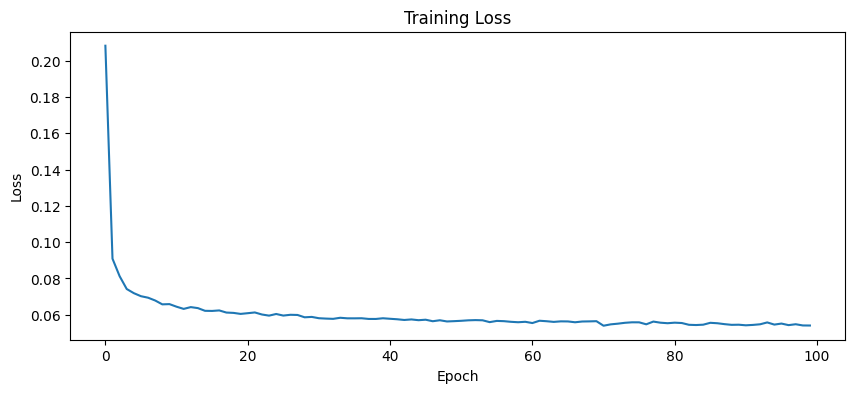

In [11]:
# Save final model
torch.save({
    'epoch': NUM_EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': losses[-1],
}, os.path.join(CHECKPOINT_DIR, 'checkpoint_final.pt'))
print("Saved final checkpoint")

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.savefig(os.path.join(CHECKPOINT_DIR, 'training_loss.png'))
plt.show()

## Generate Samples by Class

In [12]:
# Load checkpoint if needed
# checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, 'checkpoint_final.pt'), map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])
# print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")

Sampling: 100%|████████████████████████████| 1000/1000 [00:48<00:00, 20.79it/s]


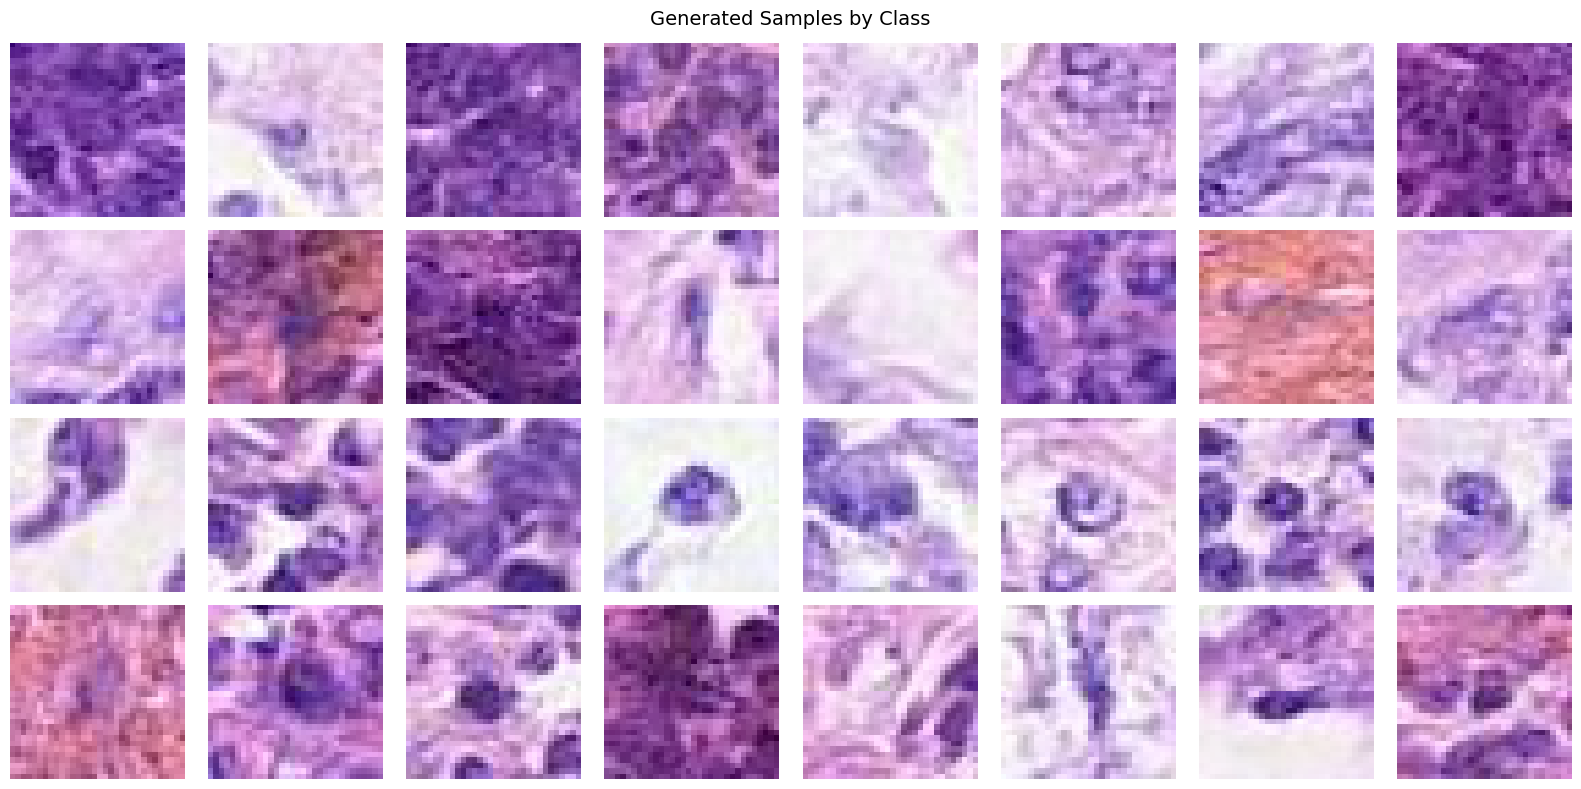

In [13]:
# Generate samples for each class
model.eval()

fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('Generated Samples by Class', fontsize=14)

for class_idx, class_name in enumerate(CLASS_NAMES):
    labels = torch.full((8,), class_idx, device=device, dtype=torch.long)
    samples = generate_samples(model, noise_scheduler, num_samples=8, class_labels=labels)

    for i in range(8):
        axes[class_idx, i].imshow(samples[i].permute(1, 2, 0).cpu())
        axes[class_idx, i].axis('off')
    axes[class_idx, 0].set_ylabel(class_name, fontsize=12, rotation=0, labelpad=60)

plt.tight_layout()
plt.savefig(os.path.join(SAMPLE_DIR, 'generated_by_class.png'), dpi=150)
plt.show()

## Generate Augmentation Data

In [14]:
def generate_augmentation_data(model, scheduler, output_dir, samples_per_class):
    """Generate synthetic images for data augmentation"""
    model.eval()

    for class_name, num_samples in samples_per_class.items():
        class_idx = CLASS_TO_IDX[class_name]
        class_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        print(f"Generating {num_samples} samples for '{class_name}'...")

        batch_size = 64
        generated = 0

        while generated < num_samples:
            current_batch = min(batch_size, num_samples - generated)
            labels = torch.full((current_batch,), class_idx, device=device, dtype=torch.long)

            samples = generate_samples(model, scheduler, num_samples=current_batch, class_labels=labels)

            for i, sample in enumerate(samples):
                img = (sample.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
                img = Image.fromarray(img)
                img.save(os.path.join(class_dir, f'synthetic_{generated + i:05d}.png'))

            generated += current_batch
            print(f"  {generated}/{num_samples}")

        print(f"  Saved to {class_dir}")

# Uncomment to generate augmentation data
# Target: ~7,000 samples per class for balanced dataset
# augmentation_samples = {
#     'epithelial': 0,        # Already has 7,157
#     'inflammatory': 750,    # 6,406 + 750 = 7,156
#     'fibroblast': 2000,     # 5,142 + 2,000 = 7,142
#     'others': 5400          # 1,739 + 5,400 = 7,139
# }
#
# generate_augmentation_data(
#     model=model,
#     scheduler=noise_scheduler,
#     output_dir=os.path.join(SAMPLE_DIR, 'augmentation'),
#     samples_per_class=augmentation_samples
# )

# Task
Modify the Google Drive mount check in the `iD2wPxlsV1Px` cell to first verify if '/content/drive' is already mounted. If it is, skip the `drive.mount` command. If not, proceed with `drive.mount('/content/drive', force_remount=False)` to attempt mounting, ensuring that the drive is mounted exactly once per session gracefully and without user prompts if it was previously mounted or timed out. Confirm the updated logic fulfills these requirements.

## Modify Google Drive Mount Check

### Subtask:
Update the `iD2wPxlsV1Px` cell to check if '/content/drive' is already mounted before attempting to mount Google Drive. If already mounted, skip the command. Otherwise, mount the drive using `force_remount=False`.


**Reasoning**:
The subtask requires modifying the `iD2wPxlsV1Px` cell to check if Google Drive is already mounted before attempting to mount it, and to use `force_remount=False` if mounting is necessary. This involves adding an import for `os` and an if-else block.

